After performing the EDA some columns were modified and some columns were added in our dataset. Since the dataset used is the same we'll be using that data for making predictions
--

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [2]:
df=pd.read_csv('data_after_EDA.csv')

In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_month,pickup_hour_of_day,dropoff_hour_of_day,distance,speed_mph,pickup_time,dropoff_time,log_trip_duration,log_distance,log_speed_mph
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,...,2,16,16,0.745502,6.709522,Afternoon,Afternoon,5.991465,0.557042,2.042456
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,...,3,23,23,2.562501,8.386366,Night,Night,7.003065,1.270463,2.239258
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,...,2,17,18,4.505212,9.919733,Evening,Evening,7.399398,1.705695,2.390571
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,...,1,9,10,1.465371,4.623433,Morning,Morning,7.039660,0.902342,1.726942
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,...,2,6,6,2.689391,11.417226,Morning,Morning,6.742881,1.305461,2.519085


In [4]:
df.shape

(729322, 24)

Before starting with the model building process there are a few steps that needs to be performed on the data such as
--

Removing the highly correlated values

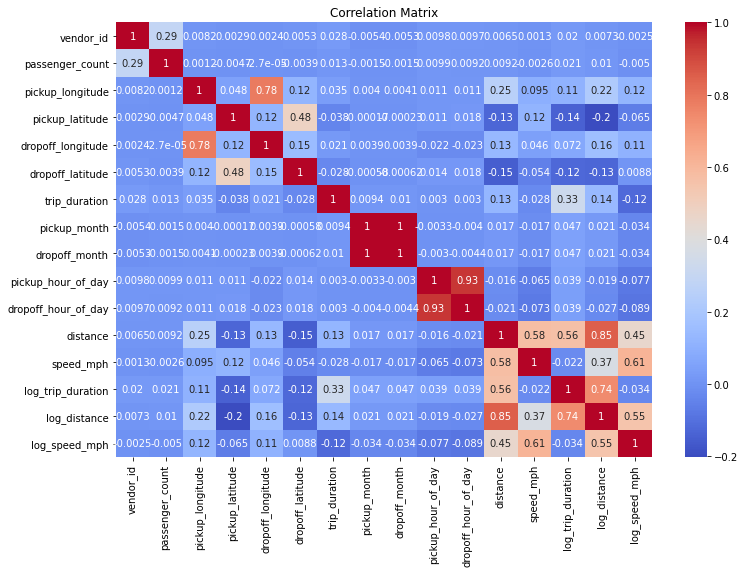

In [5]:
numeric_columns = df.select_dtypes(include=[np.number])  # Select numeric columns only
correlation= numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

According to the correlation matrix the columns that are highly correlated are pickup_hour_of_day, droppoff_hour_of_day,  pickup_month, dropoff_month. So these columns needs to be dropped

And since pickup_time and dropoff_time variables are also obtained from pickup_hour_of_day and dropoff_hour_of_day they needs to be dropped as well

In [6]:
columns_to_drop=['pickup_hour_of_day','dropoff_hour_of_day','pickup_month','dropoff_month','pickup_time','dropoff_time']

In [7]:
df = df.drop(columns=columns_to_drop)

In [8]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,distance,speed_mph,log_trip_duration,log_distance,log_speed_mph
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,Monday,Monday,0.745502,6.709522,5.991465,0.557042,2.042456
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,Friday,Friday,2.562501,8.386366,7.003065,1.270463,2.239258
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,Sunday,Sunday,4.505212,9.919733,7.399398,1.705695,2.390571
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,Tuesday,Tuesday,1.465371,4.623433,7.039660,0.902342,1.726942
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,Wednesday,Wednesday,2.689391,11.417226,6.742881,1.305461,2.519085


We calculated the logaritmic values for visualization purpose during EDA so we can drop those variables as well

In [9]:
log_columns=['log_trip_duration','log_distance','log_speed_mph']

In [10]:
df = df.drop(columns=log_columns)

We have extracted all the necessary attributes from the datetime columns so we can get rid of those columns, additionaly we won't be needing the id column as well

In [11]:
unnecessary_columns=['id','id','pickup_datetime','dropoff_datetime']

In [12]:
df = df.drop(columns=unnecessary_columns)

Moreover as we have generated the speed_mph variable using our target variable trip_duration we should remove it from the features to avoid overfitting

In [13]:
df=df.drop(columns=['speed_mph'])

In [14]:
print(df.shape)
df.head()

(729322, 11)


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,distance
0,2,1,-73.953918,40.778873,-73.963875,40.771164,N,400,Monday,Monday,0.745502
1,1,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,Friday,Friday,2.562501
2,2,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,Sunday,Sunday,4.505212
3,2,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,Tuesday,Tuesday,1.465371
4,1,1,-74.017120,40.708469,-73.988182,40.740631,N,848,Wednesday,Wednesday,2.689391


Since the model only works with numerical data, we need to one hot encode the categorical variables as well
--

In [15]:
#add dummy variable to convert textual data to numerical data through one hot encoding
df=pd.get_dummies(df,columns=['store_and_fwd_flag', 'pickup_day', 'dropoff_day'],drop_first=True)

In [16]:
df.shape

(729322, 21)

Now lets have a look at target variable
--

In [17]:
df['trip_duration'].describe()

count    7.293220e+05
mean     9.522291e+02
std      3.864626e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.630000e+02
75%      1.075000e+03
max      1.939736e+06
Name: trip_duration, dtype: float64

Text(0.5, 1.0, 'Distribution after applying log transformation')

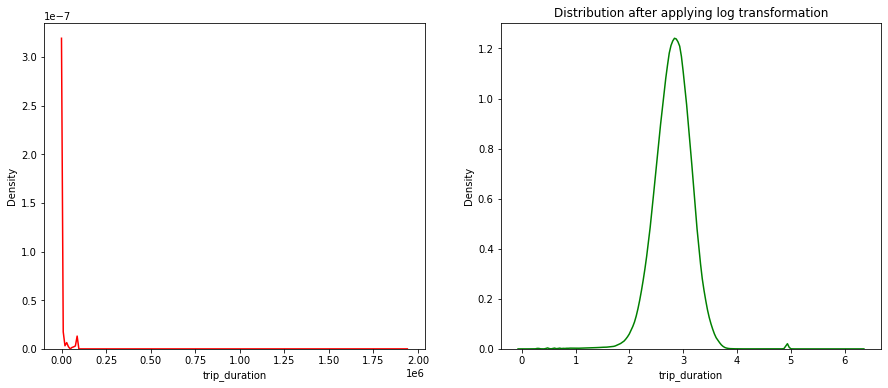

In [18]:
#Target variable (trip_duration) distribution
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,6))
sns.distplot(df['trip_duration'],color='red',ax=ax[0],hist=False, kde=True)
sns.distplot(np.log10(df["trip_duration"]),color='green',ax=ax[1],hist= False,kde= True)
ax[1].set_title("Distribution after applying log transformation")


As observed in EDA the trip_duration is a highly right skewed data, so we perform log transformation on that

Before fitting the data on the model we need to take care of the outliers as well, so that it does not affect the model building process
--

<AxesSubplot:xlabel='distance'>

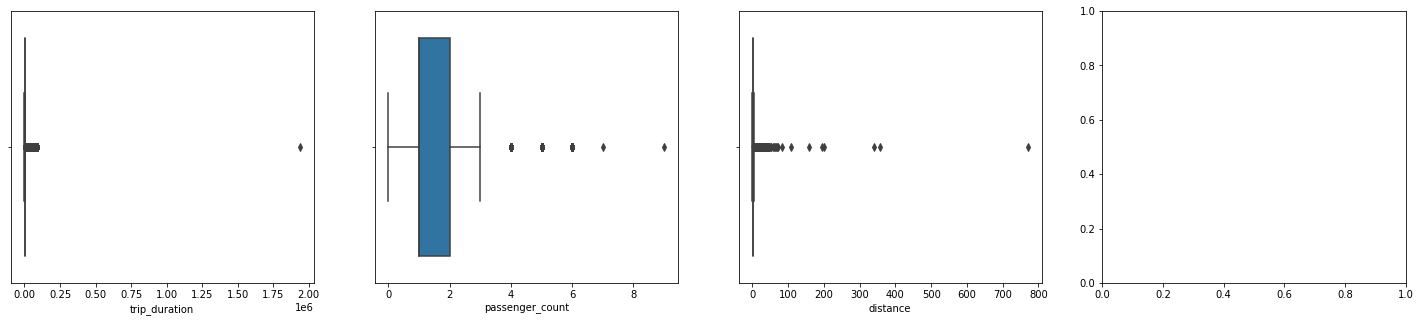

In [19]:
#boxplot for visualizing for outliers
fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(25,5))
sns.boxplot(df["trip_duration"],ax=ax[0])
sns.boxplot(df['passenger_count'],ax=ax[1])
sns.boxplot(df['distance'],ax=ax[2])
     

In [20]:
# standard deviation factor
factor = 3

# filtering trip_duratio using standard deviation
df = df[df['trip_duration'] < df['trip_duration'].mean() + factor*df['trip_duration'].std()]

# checking how many points removed
len(df)

728302

In [21]:
# standard deviation factor
factor = 3


# filtering passenger_count using standard deviation
df = df[df['passenger_count'] < df['passenger_count'].mean() + factor*df['passenger_count'].std()]

# checking how many points removed
len(df)

704265

In [22]:
# standard deviation factor
factor = 3


# filtering distance using standard deviation 
df = df[df['distance'] < df['distance'].mean() + factor*df['distance'].std()]

# checking how many points removed
len(df)

685351

<AxesSubplot:xlabel='passenger_count', ylabel='Density'>

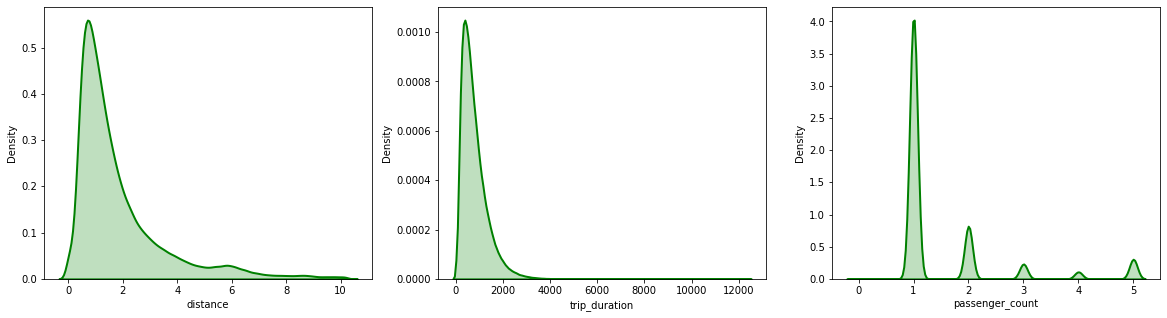

In [23]:
# Checking if the skewness is reduced or not
figure, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20,5))
sns.distplot(df['distance'], hist=False, kde=True, kde_kws= {'shade':True, 'linewidth':2}, color="green", ax=ax[0])
sns.distplot(df['trip_duration'], hist=False, kde=True, kde_kws= {'shade':True, 'linewidth':2}, color="green", ax=ax[1])
sns.distplot(df['passenger_count'], hist=False, kde=True, kde_kws= {'shade':True, 'linewidth':2}, color="green", ax=ax[2])


Since we see more otliers we perform otlier removal on the necessary variables again

In [24]:
# standard deviation factor
factor = 3

# filtering 
df = df[df['distance'] < df['distance'].mean() + factor*df['distance'].std()]

# checking how many points removed
len(df)

669691

In [25]:
# standard deviation factor
factor = 3

# filtering 
df = df[df['trip_duration'] < df['trip_duration'].mean() + factor*df['trip_duration'].std()]

# checking how many points removed
len(df)

659883

<AxesSubplot:xlabel='passenger_count', ylabel='Density'>

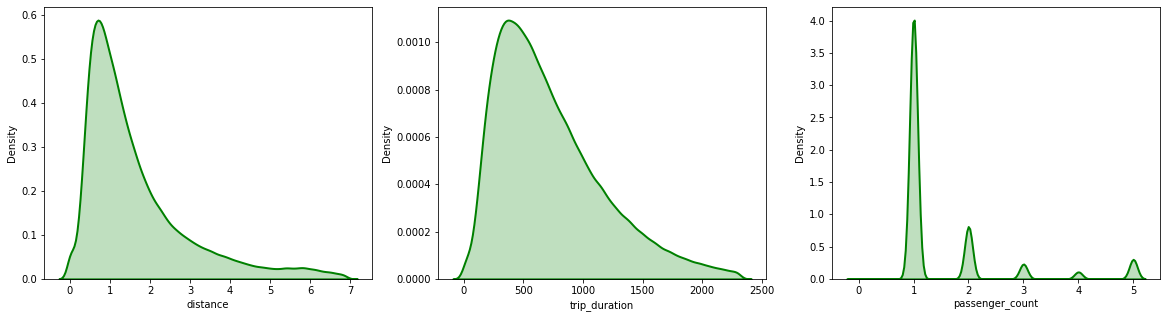

In [26]:
# Checking if the skewness is reduced or not
figure, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20,5))
sns.distplot(df['distance'], hist=False, kde=True, kde_kws= {'shade':True, 'linewidth':2}, color="green", ax=ax[0])
sns.distplot(df['trip_duration'], hist=False, kde=True, kde_kws= {'shade':True, 'linewidth':2}, color="green", ax=ax[1])
sns.distplot(df['passenger_count'], hist=False, kde=True, kde_kws= {'shade':True, 'linewidth':2}, color="green", ax=ax[2])

In [27]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,store_and_fwd_flag_Y,pickup_day_Monday,...,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,dropoff_day_Monday,dropoff_day_Saturday,dropoff_day_Sunday,dropoff_day_Thursday,dropoff_day_Tuesday,dropoff_day_Wednesday
0,2,1,-73.953918,40.778873,-73.963875,40.771164,400,0.745502,0,1,...,0,0,0,0,1,0,0,0,0,0
1,1,2,-73.988312,40.731743,-73.994751,40.694931,1100,2.562501,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,-73.997314,40.721458,-73.948029,40.774918,1635,4.505212,0,0,...,1,0,0,0,0,0,1,0,0,0
4,1,1,-74.017120,40.708469,-73.988182,40.740631,848,2.689391,0,0,...,0,0,0,1,0,0,0,0,0,1
5,2,2,-73.993614,40.751884,-73.995422,40.723862,1455,1.935970,0,0,...,1,0,0,0,0,0,1,0,0,0


Now that we've performed all the necessary steps before building a model we can now train different models to predict the trip_duration
--

We will take into consideration only the features that are important for model building

In [28]:
df.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration', 'distance',
       'store_and_fwd_flag_Y', 'pickup_day_Monday', 'pickup_day_Saturday',
       'pickup_day_Sunday', 'pickup_day_Thursday', 'pickup_day_Tuesday',
       'pickup_day_Wednesday', 'dropoff_day_Monday', 'dropoff_day_Saturday',
       'dropoff_day_Sunday', 'dropoff_day_Thursday', 'dropoff_day_Tuesday',
       'dropoff_day_Wednesday'],
      dtype='object')

In [29]:
features=['vendor_id', 'passenger_count', 'distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag_Y','pickup_day_Sunday','pickup_day_Monday',
          'pickup_day_Tuesday','pickup_day_Wednesday','pickup_day_Thursday','pickup_day_Saturday',]
#since dropoff_day and pickup_day are almost the same we can just use anyone for model building process

In [30]:
final_df=df[features]
final_df.shape

(659883, 14)

## As our target variable is a countinous variable we can say that it is a regression problem.
We will use the MSE, RMSE, R-squared and adjusted R-squared score for the evaluation purpose of the model
--

In [31]:
# A function to evaluate the models
def evaluation_metrics (x_train,y_train,y_predicted):
    MSE=round(mean_squared_error(y_true=y_train, y_pred=y_predicted),4)
    RMSE=math.sqrt(MSE)
    R2_score=r2_score(y_true=y_train, y_pred=y_predicted)
    Adjusted_R2_score=1-((1-( R2_score))*(x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1))

    print("Mean Squared Error:",MSE,"Root Mean Squared Error:", RMSE)
    print("R2 Score :",R2_score,"Adjusted R2 Score :",Adjusted_R2_score)
 
    #Plotting Actual and Predicted Values
    plt.figure(figsize=(18,6))
    plt.plot((y_predicted)[:100], color='red') 
    plt.plot(np.array(y_train)[:100], color='green')
    plt.legend(["Predicted","Actual"])
    plt.title('Actual and Predicted Trip duration')

Breaking down our data into dependent and the target variable

In [32]:
x=final_df[features]
y=df["trip_duration"]

In [33]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

Diving the data into train and test sets

In [34]:
# Importing train_test_split
x_train,x_test,y_train,y_test=train_test_split(X_scaled,y_scaled,test_size=0.3,random_state=42)

Linear Regression Model
--

In [35]:
lr=LinearRegression()
lr.fit(x_train,y_train)
a=lr.score(x_train, y_train)
y_pred_train = lr.predict(x_train)
y_pred_test = lr.predict(x_test)


Mean Squared Error: 0.4744 Root Mean Squared Error: 0.6887670143089025
R2 Score : 0.5251409112693857 Adjusted R2 Score : 0.5251265185781882


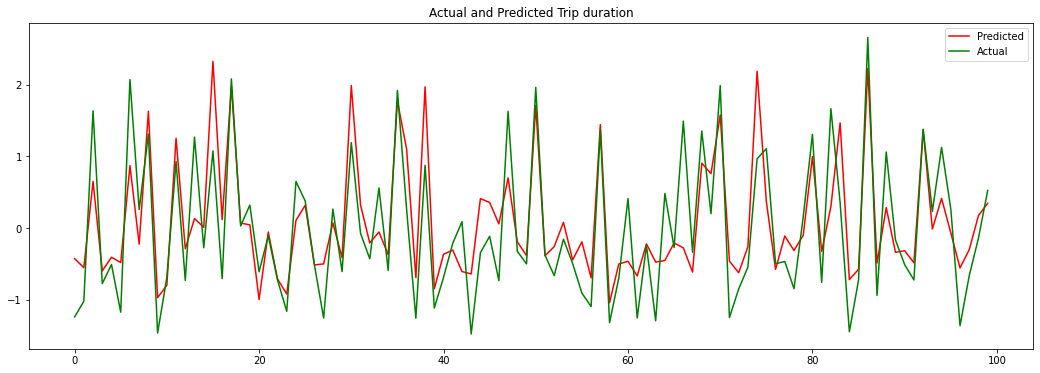

In [36]:
# evaluation metrics for train data set
evaluation_metrics(x_train,y_train,y_pred_train)

Mean Squared Error: 0.479 Root Mean Squared Error: 0.692098258919931
R2 Score : 0.5220099071744534 Adjusted R2 Score : 0.5219761013583404


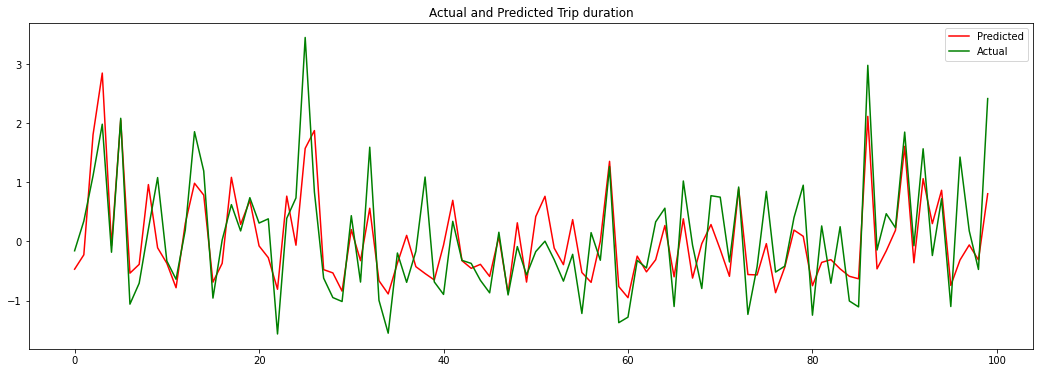

In [37]:
# evaluation metrics for test data set
evaluation_metrics(x_test,y_test,y_pred_test)

The evaluation of Linear Regression shows that the MSE and RMSE score are low which is good, but the R-squared and Adjusted R-squared score for our test set  0.52 which is a bit less. So lets try to Decision tree to train our model

Decision Tree
--

In [38]:
# Maximum depth of trees
max_depth = [6,8,10]


# Hyperparameter Grid
param_decision_tree = {'max_depth' : max_depth}
DTR = DecisionTreeRegressor()

# Grid search
decision_tree_grid = GridSearchCV(estimator=DTR,
                       param_grid = param_decision_tree,
                       cv = 5, verbose=2, scoring='r2')
decision_tree_grid.fit(x_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ........................................max_depth=6; total time=   2.0s
[CV] END ........................................max_depth=6; total time=   1.9s
[CV] END ........................................max_depth=6; total time=   2.0s
[CV] END ........................................max_depth=6; total time=   2.0s
[CV] END ........................................max_depth=6; total time=   1.9s
[CV] END ........................................max_depth=8; total time=   2.4s
[CV] END ........................................max_depth=8; total time=   2.7s
[CV] END ........................................max_depth=8; total time=   2.5s
[CV] END ........................................max_depth=8; total time=   2.3s
[CV] END ........................................max_depth=8; total time=   2.3s
[CV] END .......................................max_depth=10; total time=   2.8s
[CV] END .......................................m

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [6, 8, 10]}, scoring='r2', verbose=2)

In [39]:
decision_tree_grid.best_estimator_

DecisionTreeRegressor(max_depth=10)

In [40]:
decision_tree_grid.best_score_

0.5977197892553698

In [41]:
decision_tree_optimal_model =decision_tree_grid.best_estimator_
y_predict_train_decision_tree=decision_tree_optimal_model.predict(x_train)
y_predict_test_decision_tree=decision_tree_optimal_model.predict(x_test)

Mean Squared Error: 0.3889 Root Mean Squared Error: 0.6236184731067546
R2 Score : 0.6107475819222383 Adjusted R2 Score : 0.6107357839173475


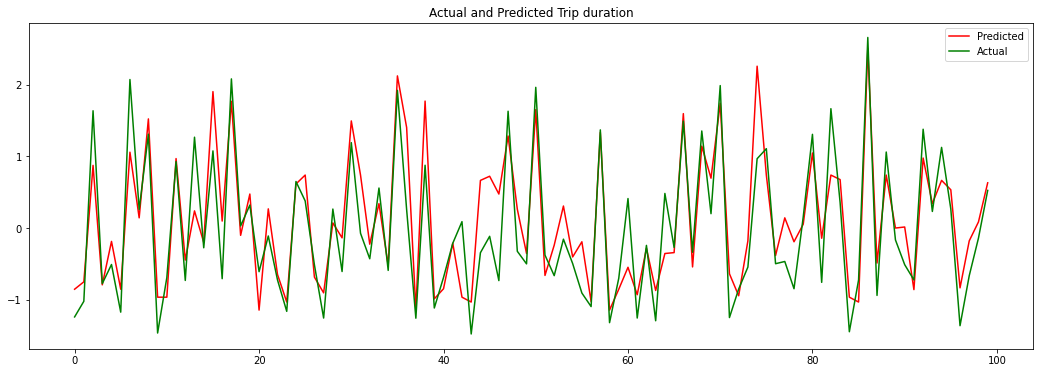

In [42]:
# evaluation metrics for train data set
evaluation_metrics(x_train,y_train,y_predict_train_decision_tree)

Mean Squared Error: 0.4043 Root Mean Squared Error: 0.6358458932791813
R2 Score : 0.5965165725620403 Adjusted R2 Score : 0.5964880362246615


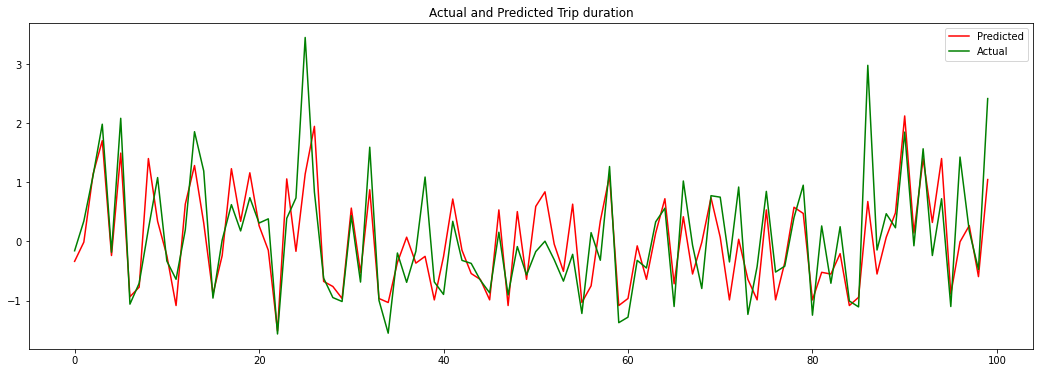

In [43]:
# evaluation metrics for test data set
evaluation_metrics(x_test,y_test,y_predict_test_decision_tree)

As compared to Linear Regression the Decision Tree has given a better R-squared and adjusted R-squared score that is around 0.59 but its still not upto the mark. Lets see if we can have a more better score with Random Forest

Random Forest
--

In [44]:
RFR=RandomForestRegressor()

In [45]:
# Maximum number of level in trees
max_depth=[12,14,16] 

# Maximum number of trees in the algorithm
n_estimators=[20,22,24]

# Max number of feature to consider at every split
max_features=[0.6]

# Hyperparameter Grid
param_grid={'n_estimators':n_estimators,
            'max_features':max_features,
            'max_depth':max_depth
            }

In [46]:
RF_grid=GridSearchCV(estimator=RFR,param_grid=param_grid,cv=3,verbose=2)

In [47]:
RF_grid.fit(x_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ....max_depth=12, max_features=0.6, n_estimators=20; total time=  27.4s
[CV] END ....max_depth=12, max_features=0.6, n_estimators=20; total time=  28.3s
[CV] END ....max_depth=12, max_features=0.6, n_estimators=20; total time=  27.8s
[CV] END ....max_depth=12, max_features=0.6, n_estimators=22; total time=  30.9s
[CV] END ....max_depth=12, max_features=0.6, n_estimators=22; total time=  30.9s
[CV] END ....max_depth=12, max_features=0.6, n_estimators=22; total time=  31.0s
[CV] END ....max_depth=12, max_features=0.6, n_estimators=24; total time=  32.7s
[CV] END ....max_depth=12, max_features=0.6, n_estimators=24; total time=  34.1s
[CV] END ....max_depth=12, max_features=0.6, n_estimators=24; total time=  33.3s
[CV] END ....max_depth=14, max_features=0.6, n_estimators=20; total time=  31.5s
[CV] END ....max_depth=14, max_features=0.6, n_estimators=20; total time=  31.7s
[CV] END ....max_depth=14, max_features=0.6, n_es

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [12, 14, 16], 'max_features': [0.6],
                         'n_estimators': [20, 22, 24]},
             verbose=2)

In [48]:
RF_grid.best_params_

{'max_depth': 16, 'max_features': 0.6, 'n_estimators': 24}

In [49]:
RF_grid.best_score_

0.6441248164412184

In [50]:
Random_Forest_optimal_model =RF_grid.best_estimator_
y_predict_train_Random_Forest=Random_Forest_optimal_model.predict(x_train)
y_predict_test_Random_Forest=Random_Forest_optimal_model.predict(x_test)

Mean Squared Error: 0.2776 Root Mean Squared Error: 0.5268775948927796
R2 Score : 0.7221965250001477 Adjusted R2 Score : 0.7221881049451795


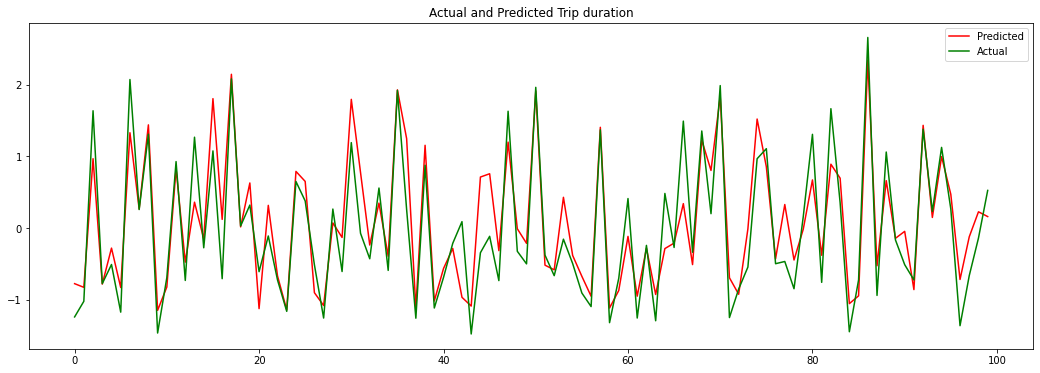

In [51]:
# evaluation metrics for train data set
evaluation_metrics(x_train,y_train,y_predict_train_Random_Forest)

Mean Squared Error: 0.3559 Root Mean Squared Error: 0.5965735495309862
R2 Score : 0.6447959148579856 Adjusted R2 Score : 0.6447707930737371


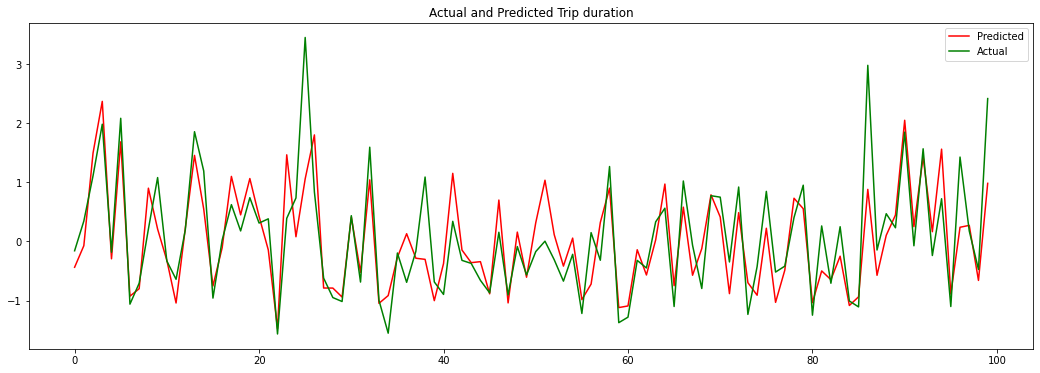

In [52]:
# evaluation metrics for test data set
evaluation_metrics(x_test,y_test,y_predict_test_Random_Forest)

Here the Random Forest has given a better result on both training and test set with the training set score of 0.72 and test score of 0.64

In [55]:
# All evaluation metrics values
print('Test Scores for both the Models')
score_values=[[0.479,0.692,0.522,0.521],
              [0.404,0.635,0.596,0.596],
              [0.355,0.596,0.644,0.644]]
# Create the pandas DataFrame
df_score = pd.DataFrame(score_values,columns=['MSE', 'RMSE', 'R2', 'Adjusted_R2'], index=['Linear Regression', 'Decision Tree','Random Forest'])
df_score



Test Scores for both the Models


,MSE,RMSE,R2,Adjusted_R2
Linear Regression,0.479,0.692,0.522,0.521
Decision Tree,0.404,0.635,0.596,0.596
Random Forest,0.355,0.596,0.644,0.644


We can learly see that not only the R-squared and adjusted R-squared scores are better, but also the error scores for Random forest are the minimum which is good

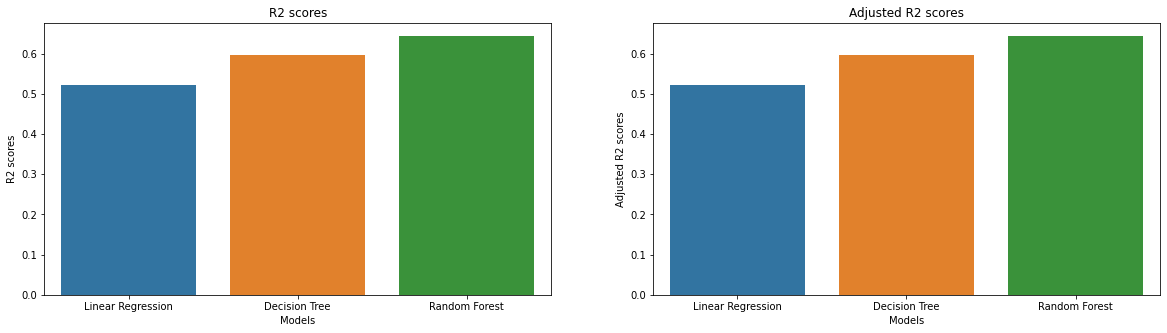

In [56]:
#visualisation for R2 score
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 5))
models= ['Linear Regression', 'Decision Tree','Random Forest']
ax1.set_title('R2 scores')
ax = sns.barplot(x = models, y='R2', data =df_score , ax = ax1)
ax.set_xlabel('Models')
ax.set_ylabel('R2 scores')

#visualisation for adjustedR2 
ax = sns.barplot(x = models, y='Adjusted_R2',  data = df_score, ax = ax2)
ax2.set_title('Adjusted R2 scores')
ax.set_xlabel('Models')
ax.set_ylabel('Adjusted R2 scores')
plt.show()

It is clearly observed that the Random Forest Algorithm performs much better than other Models
--